In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
## Set crypto variable
crypto = 'BTC'
yf_crypto = 'BTC'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Create dataframe with 5 most recent years
crypto_df = crypto_df.tail(1825)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-05,70568.351562,71735.414062,70390.710938,71082.820312,32810771409
2024-06-06,71082.843750,71625.734375,70119.125000,70757.164062,25223152007
2024-06-07,70759.187500,71907.851562,68507.257812,69342.585938,36188381096
2024-06-08,69324.179688,69533.320312,69210.742188,69305.773438,14262185861
2024-06-09,69297.492188,69817.523438,69160.843750,69647.992188,13534028500


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

69647.9921875

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.999531,0.999212,0.998923,0.657475
High,0.999531,1.000000,0.999070,0.999534,0.663038
Low,0.999212,0.999070,1.000000,0.999430,0.647356
Close,0.998923,0.999534,0.999430,1.000000,0.656087
Volume,0.657475,0.663038,0.647356,0.656087,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2014-09-17,457.334015,21056800
2014-09-18,424.440002,34483200
2014-09-19,394.795990,37919700
2014-09-20,408.903992,36863600
2014-09-21,398.821014,26580100
...,...,...
2024-06-05,71082.820312,32810771409
2024-06-06,70757.164062,25223152007
2024-06-07,69342.585938,36188381096


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate volatility
df_close_ma.loc[:, 'Percent Change'] = df_close_ma['Close'].pct_change()*100
df_close_ma.loc[:, 'Volatility'] = df_close_ma['Percent Change'].rolling(10).std(ddof=0) * np.sqrt(252)

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,Volatility,SMA10,SMA30,SMA50
Date,,,,,,
2014-11-05,339.485992,19817200,168.979182,337.899701,361.337801,372.766840
2014-11-06,349.290009,18797000,161.403803,337.529800,361.774568,370.605960
2014-11-07,342.415009,16834200,126.099281,336.009500,361.423735,368.965460
2014-11-08,345.488007,8535470,133.842444,336.999200,360.772468,367.979301
2014-11-09,363.264008,24205600,180.960085,338.795102,360.829201,367.066501


,Close,Volume,Volatility,SMA10,SMA30,SMA50
Date,,,,,,
2024-06-05,71082.820312,32810771409,19141.700356,68703.917969,66593.930208,65289.861406
2024-06-06,70757.164062,25223152007,21352.858751,68840.178906,66874.675130,65479.470859
2024-06-07,69342.585938,36188381096,21262.402894,68944.815625,67146.496615,65596.067500
2024-06-08,69305.773438,14262185861,20019.475651,69117.583594,67355.023698,65705.311563
2024-06-09,69647.992188,13534028500,19734.430198,69245.883594,67650.197526,65798.382578


<Axes: xlabel='Date'>

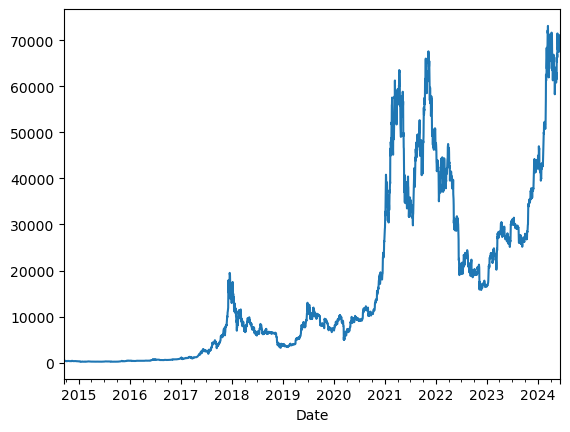

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2014-09-17,457.334015,21056800
1,2014-09-18,424.440002,34483200
2,2014-09-19,394.795990,37919700
3,2014-09-20,408.903992,36863600
4,2014-09-21,398.821014,26580100
...,...,...,...
3548,2024-06-04,70567.765625,33149696545
3549,2024-06-05,71082.820312,32810771409
3550,2024-06-06,70757.164062,25223152007
3551,2024-06-07,69342.585938,36188381096


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

16:40:36 - cmdstanpy - INFO - Chain [1] start processing
16:40:36 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
3638,2024-09-02
3639,2024-09-03
3640,2024-09-04
3641,2024-09-05
3642,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3613,2024-08-08,56079.123461,48878.838650,61983.752638,55701.087593,56422.724484,-694.720050,-694.720050,-694.720050,-10.558249,-10.558249,-10.558249,-684.161801,-684.161801,-684.161801,0.0,0.0,0.0,55384.403411
3614,2024-08-09,56131.274974,48966.021517,62226.574177,55726.104042,56491.312663,-651.460421,-651.460421,-651.460421,-9.991221,-9.991221,-9.991221,-641.469200,-641.469200,-641.469200,0.0,0.0,0.0,55479.814553
3615,2024-08-10,56183.426486,49217.265122,62623.799701,55760.108336,56560.552796,-615.390361,-615.390361,-615.390361,-8.655509,-8.655509,-8.655509,-606.734852,-606.734852,-606.734852,0.0,0.0,0.0,55568.036125
3616,2024-08-11,56235.577999,48627.021867,62689.782899,55776.918715,56627.282475,-610.490041,-610.490041,-610.490041,-29.726605,-29.726605,-29.726605,-580.763436,-580.763436,-580.763436,0.0,0.0,0.0,55625.087957
3617,2024-08-12,56287.729511,48172.204857,62476.916392,55806.562468,56692.025794,-533.511748,-533.511748,-533.511748,30.694506,30.694506,30.694506,-564.206254,-564.206254,-564.206254,0.0,0.0,0.0,55754.217763
3618,2024-08-13,56339.881024,49140.946024,62078.695461,55846.822185,56768.873780,-573.334286,-573.334286,-573.334286,-15.789222,-15.789222,-15.789222,-557.545065,-557.545065,-557.545065,0.0,0.0,0.0,55766.546738
3619,2024-08-14,56392.032537,48713.591589,62655.187738,55881.721777,56835.167376,-517.053970,-517.053970,-517.053970,44.026300,44.026300,44.026300,-561.080270,-561.080270,-561.080270,0.0,0.0,0.0,55874.978566
3620,2024-08-15,56444.184049,49208.902979,62954.441366,55922.186146,56926.435188,-585.482044,-585.482044,-585.482044,-10.558249,-10.558249,-10.558249,-574.923795,-574.923795,-574.923795,0.0,0.0,0.0,55858.702005
3621,2024-08-16,56496.335562,48697.858861,62785.987324,55955.048566,57009.797555,-608.988089,-608.988089,-608.988089,-9.991221,-9.991221,-9.991221,-598.996868,-598.996868,-598.996868,0.0,0.0,0.0,55887.347473
3622,2024-08-17,56548.487074,49263.289182,62942.980029,55935.845267,57099.983289,-641.688275,-641.688275,-641.688275,-8.655509,-8.655509,-8.655509,-633.032766,-633.032766,-633.032766,0.0,0.0,0.0,55906.798799


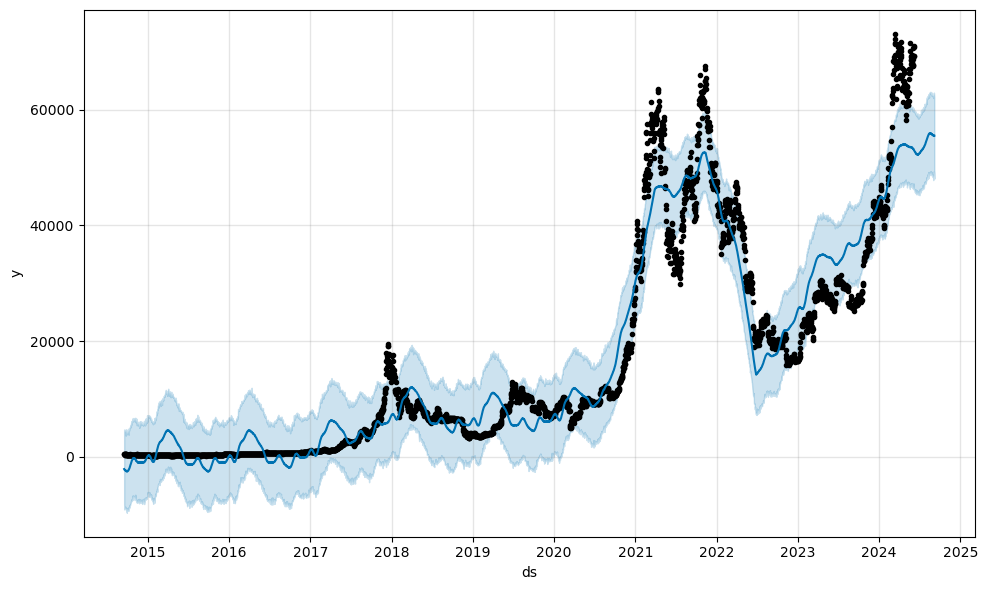

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,52810.608099,45961.088958,59516.897414
2024-06-10,52801.371990,45779.521417,59604.064175
2024-06-11,52685.716565,45701.921849,59496.432809
2024-06-12,52677.849774,46268.087386,59225.427598
2024-06-13,52558.075210,45819.658060,59702.488366
...,...,...,...
2024-09-02,55568.398881,48474.026280,62445.526164
2024-09-03,55505.520803,48599.781132,62596.522598
2024-09-04,55553.566525,49354.827908,62950.045147


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

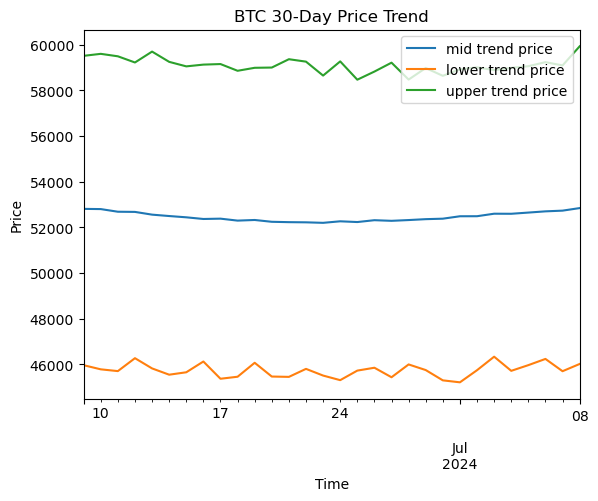

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

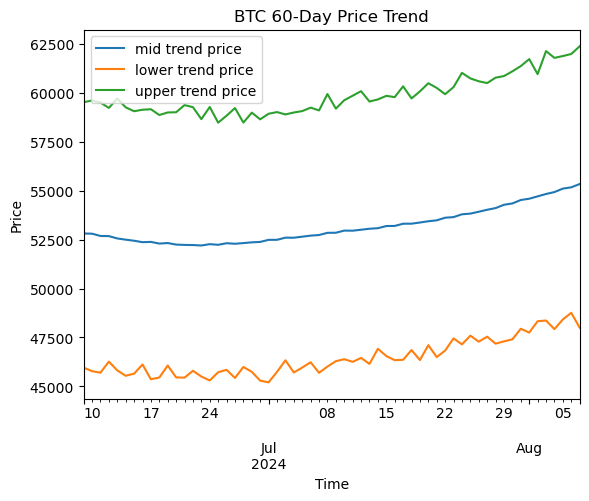

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

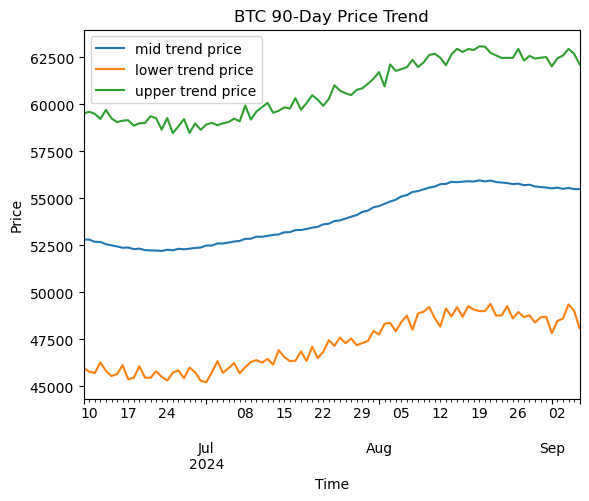

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')   
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

69305.7734375

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

52810.608098739125

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

61058.19076811956

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

52781.96213370022

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

52805.33501037984

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

55403.16030412607

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

55335.487076039244

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.135

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.093

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

-0.094

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

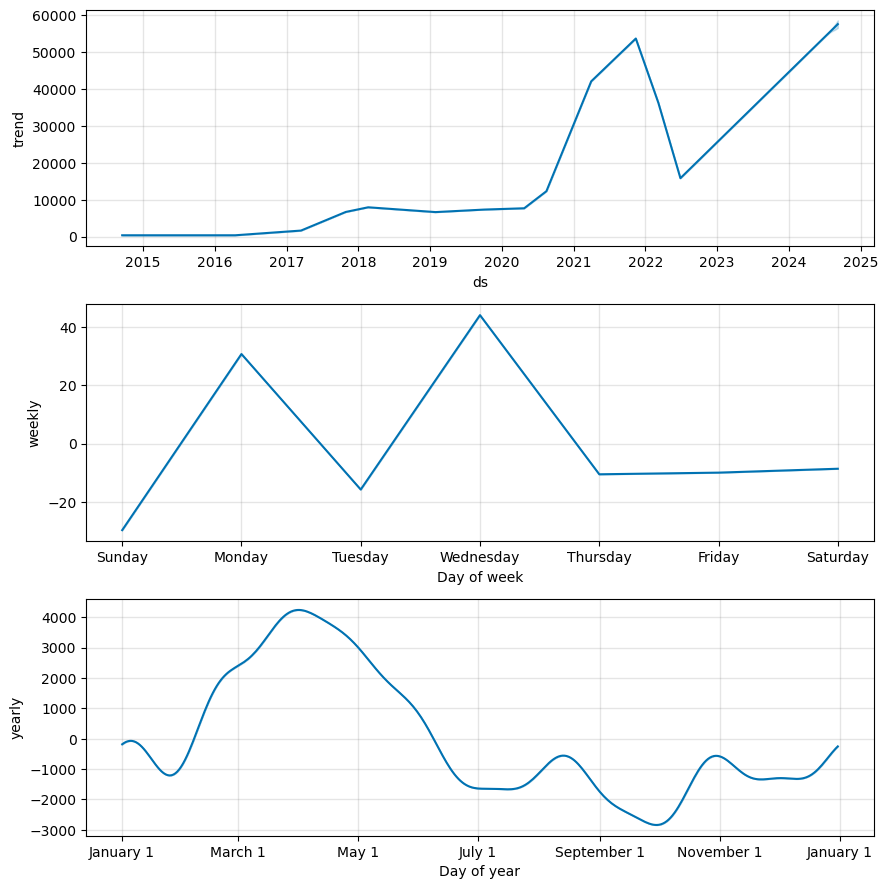

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

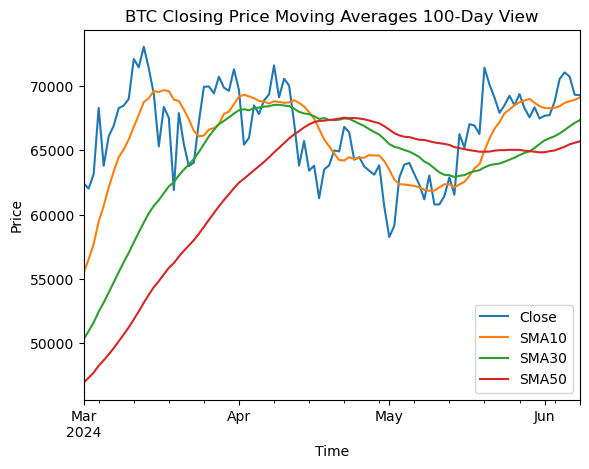

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

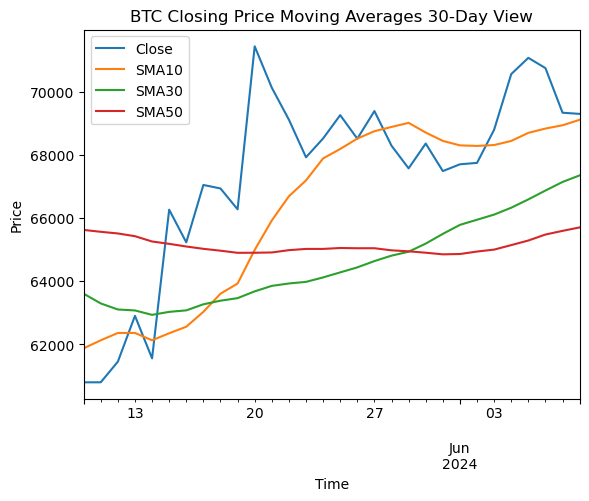

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View') 
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629
AVAX,32.29003143310547,-0.061383912293528464,0.006255814491331391,0.188757389641659
BNB,682.6651611328125,-0.25945675235825627,-0.21619087415535265,-0.19462572272913758
BONK,2.700000004551839e-05,0.19694570130627698,0.3277996886564134,0.4415377509818921
BTC,69305.7734375,-0.1351637782567381,-0.09261706566887273,-0.09372540555309616

